# Task 2.1 Streaming Data Visualisation

# Helper Functions

In [1]:
#this function takes in an array containing data from different producers and returns the 
#air_temperature_celcius data from producer1, if no data from producer1 is present, it returns None
def get_producer1_air_temp(data):
    
    if data[0] == "producer1":
        return data[1]["air_temperature_celcius"]
    
    else:
        return None
    
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)


# Plotting incoming data

<IPython.core.display.Javascript object>


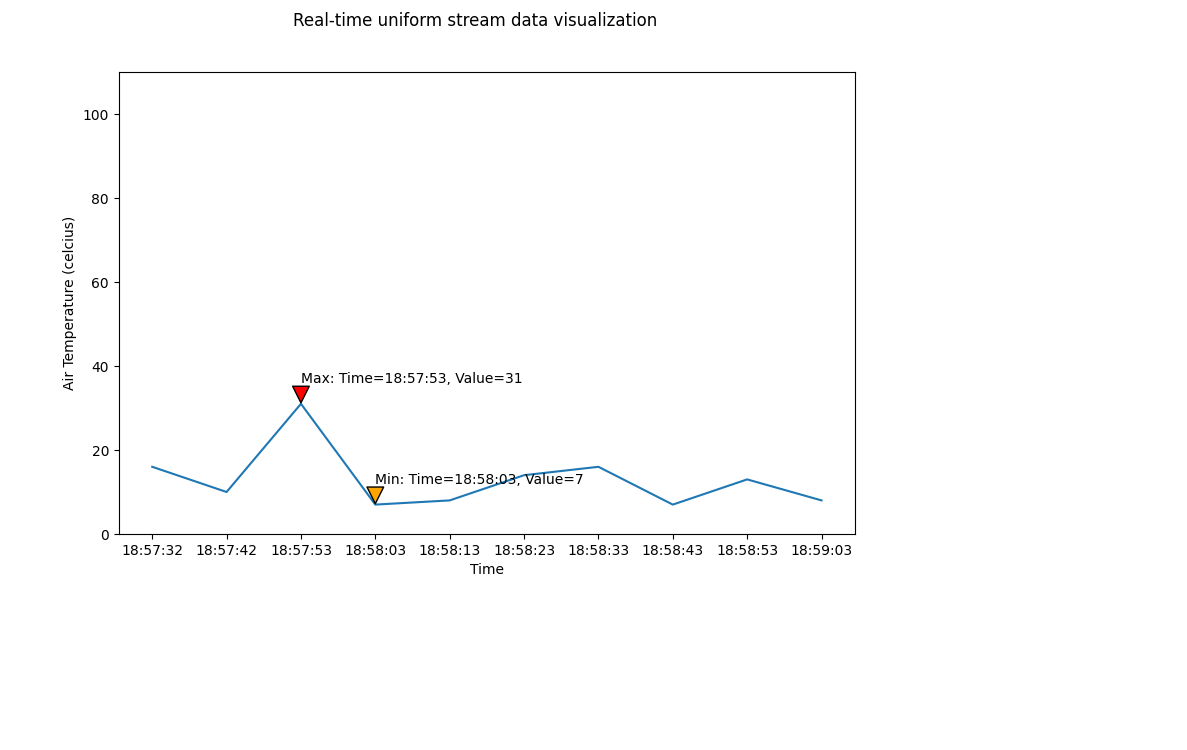

KeyboardInterrupt: 

In [2]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'assignment'

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=200000, # stop iteration if no message after 20 sec
#                                    auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            
            #use json loads function, this makes data an array where each element is 
            #containing data from the three producers
            data = loads(data)
            
            #extract just the producer1 data since only producer1 outputs air temperature data
            producer1_air_temp_data = get_producer1_air_temp(data)

            if producer1_air_temp_data is not None:
            
                x.append(dt.datetime.now().strftime("%X")) 
                y.append(int(producer1_air_temp_data))
                
                # we start plotting only when we have 10 data points
                if len(y) > 1:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Air Temperature (celcius)')
                    ax.set_ylim(0,110) 
                    ax.set_yticks([0,20,40,60,80,100])
                    annotate_max(x, y, ax)
                    annotate_min(x, y, ax)
                    fig.canvas.draw()
                    
                    if len(y) > 10:
                        x.pop(0) # removing the item in the first position
                        y.pop(0)

                    
                    
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

# Task 2.2 Static Data Visualisation

## Getting data from mongodb

In [149]:
import pymongo
from pymongo import MongoClient

client = MongoClient()
db = client.fit3182_assignment_db

In [150]:
collection_climate = db.climate_partb
collection_hotspot = db.hotspot_partb

## 2.a) Plot barchart to show total fires for each hour

In [151]:
#gather all hotspot data
#criteria is empty as we want all the data
criteria = {}  

results = collection_hotspot.find(criteria)

In [152]:
#get fires for each hour
res = []
for document in results:
    date_time_data = document["datetime"]
    res.append(int(date_time_data.strftime("%H")))
    
#calculate frequencies for each hour
freq = [0] * 24

for i in res:
    freq[i] += 1

<IPython.core.display.Javascript object>


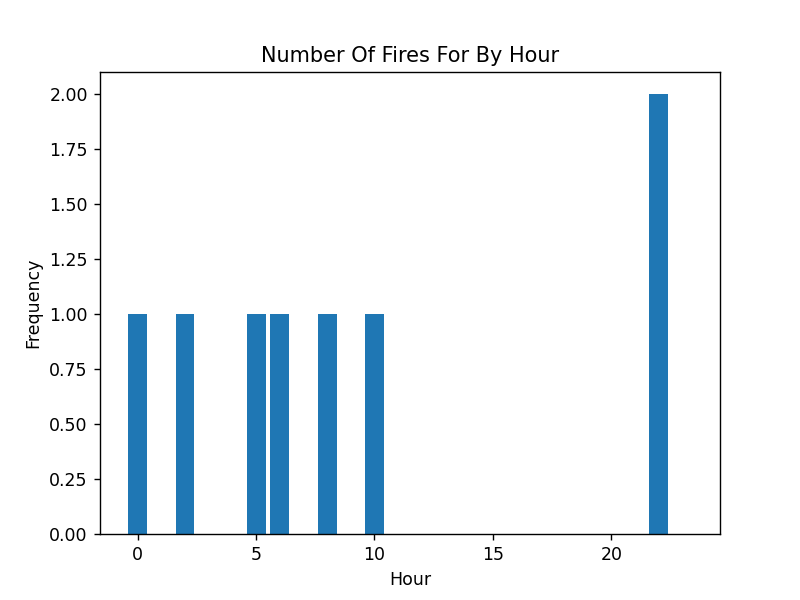

In [153]:
#plot bar plot
f, ax = plt.subplots()

plt.bar(list(range(0, 24)), freq)
plt.title("Number Of Fires For By Hour")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.show()

## 2.b) Plot fires using Folium

In [154]:
import folium

In [155]:
#plot base map (these co-ordinates were chosen by viewing the data and 
#selecting most common latitude and longitude)
fire_map = folium.Map(location = [-36, 145])

In [156]:
#get all fires and climate data
#criteria is empty as we want all the data
criteria = {}  

fire_data = collection_hotspot.find(criteria)
climate_data = collection_climate.find(criteria)

In [157]:
date_data = dt.datetime(2022, 3, 8, 0, 0)
criteria = {"date" : {"$eq" : date_data} }
    
climate_data = collection_climate.find(criteria)

In [158]:
#for each fire, get the corresponding data from climate_data and plot on folium
tooltip = "Click for more info"
for fire in fire_data:
    
    #get climate data for same date as fire, we know that climate_date has 0 hour and 0 min so we do not 
    #need to do a range search
    date_data = fire["date"]
    criteria = {"date" : {"$eq" : date_data} }
    
    climate_data = collection_climate.find(criteria)
    #there is only one datapoint in cliate data regarding a single date
    for fire_climate in climate_data:
    
        #get all corresponding data from the climate data

        plot_air_temp = fire_climate["air_temperature_celcius"]
        plot_humidity = fire_climate["relative_humidity"]
        plot_air_temp = fire_climate["air_temperature_celcius"]

        #get other data from our fire
        plot_surface_temp = fire["surface_temperature_celcius"]
        plot_confidence = fire["confidence"]
        plot_lat = fire["latitude"]
        plot_long = fire["longitude"]

        plot_fire_type = fire["cause_of_fire"]

        if plot_fire_type == "natural":
            folium.Marker(
                location = [plot_lat, plot_long],
                popup = "air_temp:" + str(plot_air_temp) + "  " + "surface_temp:" + str(plot_surface_temp) +
                "  " + "humidity:" + str(plot_humidity) + "  " + "confidence:" + str(plot_confidence),
                icon = folium.Icon(color = "blue")

            ).add_to(fire_map)

        else:
            folium.Marker(
                location = [plot_lat, plot_long],
                popup = "air_temp:" + str(plot_air_temp) + "  " + "surface_temp:" + str(plot_surface_temp) +
                "  " + "humidity:" + str(plot_humidity) + "  " + "confidence:" + str(plot_confidence),
                icon = folium.Icon(color = "red")

            ).add_to(fire_map)
            
fire_map